# DATSCI W261 ASSIGNMENT 2
Section 2<br/>
Student: Kuan Lin<br/>
Date: 1/23/2016

* <b>HW2.0. What is a race condition in the context of parallel computation? Give an example. What is MapReduce? How does it differ from Hadoop? Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.</b>

<p>Race condition occurs when multiple threads or processes attempting to access and write to a shared object.  If no proper synchronization, some threads may retrieve incorrect/staled data while the shared object is being modified by a different thread.  An example would be if multiple threads are trying to increment an integer in a shared memory.  Because integer increment is not atomic, if multiple threads trying to increment the integer simultaneously, one thread may be trying to increment on a staled value, while the actual value has already been modified by a different thread.</p>
<p>
MapReduce is a programming model that first produces a new sequence of objects by applying a function (map) to an existing sequence of objects, and aggregate results in the newly created sequence (reduce).  The map step is often done in parrallel.<br/>
Hadoop is an open source framework consisting of a distributed file system and also an executing engine that can execute codes in a distributed fashion via the MapReduce paradigm.
</p>
<p>
Hadoop is based on functional programming paradigm, which treats computation as mathmatical evaluations and avoid producing side effects and changing object states.  The code block below shows how to calculate sum of squares of a list of integers using functional paradigm.
</p>

In [1]:
# MapReduce example
# calculating sum of squares with functional programming paradigm

input = [1, 2, 3, 4, 5]

# map step
input_squares = map(lambda x:x**2, input)
# reduce step
results = reduce(lambda x1,x2:x1+x2, input_squares)

print results

55


* <b>HW2.1. Sort in Hadoop MapReduce</b>
* Given as input: Records of the form `<integer, “NA”>`, where integer is any integer, and “NA” is just the empty string. Output: sorted key value pairs of the form `<integer, “NA”>` in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.
* Write code to generate N  random records of the form `<integer, “NA”>`. Let N = 10,000. Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers


If we have multiple reducers, we will need one more script to perform merge sort using the output files from all of the reducers.  This is because we do not have control which intermediate key-value pairs is sent to which reducer, and thus each output files may have skipped numbers.

In [9]:
%%writefile generateNRandom.py
#!/usr/bin/python
# Generate N random integers
import sys
from random import randint

writer = open("hw2_1.txt", 'w')
N = int(sys.argv[1])
# generate N random integers
for i in xrange(N):
    writer.write(str(randint(0, N)) + '\n')
writer.close()
print "file written"

Overwriting generateNRandom.py


In [10]:
!chmod +x generateNRandom.py; python generateNRandom.py 10000

file written


In [2]:
# put the file on hdfs
!hdfs dfs -mkdir /w261/hw2;
!hdfs dfs -mkdir /w261/hw2/hw2_1;
!hdfs dfs -put hw2_1.txt /w261/hw2/hw2_1/hw2_1.txt

In [18]:
%%writefile mapper.py
#!/usr/bin/python
# no need to do anything in the mapper, just pass along the numbers and let Hadoop do the sorting
import sys
for line in sys.stdin:    
    print "%s" % (line.strip())

Overwriting mapper.py


In [19]:
%%writefile reducer.py
#!/usr/bin/python
# just printing the numbers.  Actual sorting is done in hadoop setup
import sys
for line in sys.stdin:    
    print "%s" % (line.strip())

Overwriting reducer.py


In [26]:
!cp mapper.py /data/w261/hw2/mapper.py; cp reducer.py /data/w261/hw2/reducer.py;
!chmod +x /data/w261/hw2/mapper.py; chmod +x /data/w261/hw2/reducer.py;
#!hdfs dfs -rm -r /w261/hw2/hw2_1/output;
# the key is to set mapred.text.key.comparator.options=-nr, meaning reverse numerical sorting
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/lib/hadoop-*streaming*.jar -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator -D mapred.text.key.comparator.options=-nr -mapper /data/w261/hw2/mapper.py -reducer /data/w261/hw2/reducer.py -input /w261/hw2/hw2_1/hw2_1.txt -output /w261/hw2/hw2_1/output;

16/01/24 05:26:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /w261/hw2/hw2_1/output
packageJobJar: [] [/usr/lib/hadoop/lib/hadoop-streaming-2.6.0.jar] /tmp/streamjob1368099165353184764.jar tmpDir=null
16/01/24 05:26:54 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 05:26:55 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 05:26:56 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 05:26:56 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 05:26:56 INFO Configuration.deprecation: mapred.output.key.comparator.class is deprecated. Instead, use mapreduce.job.output.key.comparator.class
16/01/24 05:26:56 INFO Configuration.deprecation: mapred.text.key.comparator.options is deprecated. Instead, use mapreduce.partition.keycomparator.options
16/01/24 05:26:57 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_145360426

In [27]:
# display 10 biggest numbers:
!hdfs dfs -cat /w261/hw2/hw2_1/output/part-00000 | head -10

10000	
10000	
9999	
9997	
9997	
9996	
9992	
9992	
9992	
9991	
cat: Unable to write to output stream.


In [28]:
# display 10 smallest numbers:
!hdfs dfs -cat /w261/hw2/hw2_1/output/part-00000 | tail -10

4	
4	
3	
3	
3	
1	
0	
0	
0	
0	


* <b>HW2.2.  WORDCOUNT
* Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.</b>

In [30]:
# put the enronn file on hdfs
!hdfs dfs -put enronemail_1h.txt /w261/hw2/enronemail_1h.txt

In [53]:
%%writefile mapper.py
#!/usr/bin/python
import sys
import re
import string
# split by spaces, fullstops, and comma
patt = re.compile('[\s|\.|,]')
for line in sys.stdin:
    line = line.strip()
    if line == '': continue
    lineArr = line.split('\t')
    # skip bad entrieds
    if len(lineArr) != 4: continue
    subject = lineArr[2]
    body = lineArr [3]
    subject_body = subject + ' ' + body
    # remove punctuations
    subject_body = subject_body.translate(string.maketrans("",""), string.punctuation)
    words = re.split(patt, subject_body)
    for word in words:
        word = word.strip()
        if word != '':
            print '%s\t%s' % (word, 1)

Overwriting mapper.py


In [35]:
%%writefile reducer.py
#!/usr/bin/python
from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print '%s\t%s' % (current_word, current_count)

Overwriting reducer.py


In [56]:
!cp mapper.py /data/w261/hw2/mapper.py; cp reducer.py /data/w261/hw2/reducer.py;
!chmod +x /data/w261/hw2/mapper.py; chmod +x /data/w261/hw2/reducer.py;
!hdfs dfs -rm -r /w261/hw2/hw2_2_output;
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/lib/hadoop-*streaming*.jar -mapper mapper.py -file /data/w261/hw2/mapper.py -reducer reducer.py -file /data/w261/hw2/reducer.py -input /w261/hw2/enronemail_1h.txt -output /w261/hw2/hw2_2_output;

16/01/24 06:53:45 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /w261/hw2/hw2_2_output
16/01/24 06:53:47 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/data/w261/hw2/mapper.py, /data/w261/hw2/reducer.py] [/usr/lib/hadoop/lib/hadoop-streaming-2.6.0.jar] /tmp/streamjob3052510899272968637.jar tmpDir=null
16/01/24 06:53:52 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 06:53:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 06:53:54 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 06:53:55 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 06:53:55 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453604265894_0019
16/01/24 06:53:56 INFO impl.YarnClientImpl: Submitted application application_1453604265894_0019
16/01/24 06:53:56 INFO mapreduce.Job: 

In [51]:
# examine the word "assistance"
!hdfs dfs -cat /w261/hw2/hw2_2_output/part-00000 | grep assistance

assistance	9


The above number is less than 10 because one of the record containing the word "assistance" does not have the properly formated field width.

* <b>HW2.2.1  Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)</b>

In [59]:
%%writefile mapper.py
#!/usr/bin/python
# I am using the word count as the key and ask Hadoop to do descending sort.  This should now give me the top-10 token
import sys
for line in sys.stdin:
    line = line.strip()
    if line == '': continue
    print '\t'.join([line.split('\t')[1], line.split('\t')[0]])

Overwriting mapper.py


In [67]:
%%writefile reducer.py
#!/usr/bin/python
# no need to do much, descending sort is done in hadoop command line (see next cell).
import sys
# print out only the top 10 tokens
top_n = 10
printcnt = 0
for line in sys.stdin:
    line = line.strip()
    if printcnt < top_n:
        print '\t'.join([line.split('\t')[1], line.split('\t')[0]])
        printcnt += 1
    else:
        break

Overwriting reducer.py


In [68]:
!cp mapper.py /data/w261/hw2/mapper.py; cp reducer.py /data/w261/hw2/reducer.py;
!chmod +x /data/w261/hw2/mapper.py; chmod +x /data/w261/hw2/reducer.py;
!hdfs dfs -rm -r /w261/hw2/hw2_2_1_output;
# -D mapred.text.key.comparator.options=-nr cause hadoop to do numerically descending sort.  Word count is the key
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/lib/hadoop-*streaming*.jar -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator -D mapred.text.key.comparator.options=-nr -mapper mapper.py -file /data/w261/hw2/mapper.py -reducer reducer.py -file /data/w261/hw2/reducer.py -input /w261/hw2/hw2_2_output/part-00000 -output /w261/hw2/hw2_2_1_output;

16/01/24 07:26:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /w261/hw2/hw2_2_1_output
16/01/24 07:26:48 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/data/w261/hw2/mapper.py, /data/w261/hw2/reducer.py] [/usr/lib/hadoop/lib/hadoop-streaming-2.6.0.jar] /tmp/streamjob4936071954852985045.jar tmpDir=null
16/01/24 07:26:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 07:26:54 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 07:26:56 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 07:26:56 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 07:26:56 INFO Configuration.deprecation: mapred.output.key.comparator.class is deprecated. Instead, use mapreduce.job.output.key.comparator.class
16/01/24 07:26:56 INFO Configuration.deprecation: mapred.text.key.comparato

In [69]:
# the top 10 tokens:
!hdfs dfs -cat /w261/hw2/hw2_2_1_output/part-00000

the	1207
to	941
and	622
of	539
a	518
you	421
in	402
your	381
for	358
on	254


* <b>HW2.3. Multinomial NAIVE BAYES with NO Smoothing
* Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters).
* Count up how many times you need to process a zero probabilty for each class and report.
* Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see.</b>

In [76]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Kuan Lin
## Description: mapper code for HW1.5

import sys
import re
import string

useAllWords = True
findwords = None

spam_word_counts = {}
ham_word_counts = {}
spam_total_words = 0
ham_total_words = 0

def findWordCount(doc, word):
	count = 0
	for w in doc.split(' '):
		if w == word: count += 1
	return count

for line in sys.stdin:
	line = line.strip().lower()
	if line == "": continue
	lineArr = line.split('\t')
	# check data integrity.  each valid line should have 4 fields, with second field equals either 0 or 1
	if len(lineArr) != 4 or (lineArr[1] != "0" and lineArr[1] != "1"): continue
	
	spam_flag = lineArr[1]
	subject_body = lineArr[2] + ' ' + lineArr[3]
	# remove punctuations
	subject_body = subject_body.translate(string.maketrans("",""), string.punctuation).strip().lower()
	all_words = [word.strip() for word in subject_body.split(' ') if word.strip() != '']
	#print str(all_words)
	if useAllWords:
		findwords = set([w for w in all_words])
	
	if spam_flag == "1":
		spam_total_words += len(all_words)
	else:
		ham_total_words += len(all_words)
		
	for word in findwords:
		#pattern = re.compile('[\s+]?(' + word + ')[\s+]?')
		if spam_flag == "1":
			if word in spam_word_counts: spam_word_counts[word] += findWordCount(subject_body, word)
			else: spam_word_counts[word] = findWordCount(subject_body, word)
		else:
			if word in ham_word_counts: ham_word_counts[word] += findWordCount(subject_body, word)
			else: ham_word_counts[word] = findWordCount(subject_body, word)
			
print '\n'.join([word + '\t' + str(spam_word_counts[word]) + '\t1' for word in spam_word_counts] + 
[word + '\t' + str(ham_word_counts[word]) + '\t0' for word in ham_word_counts] +
['class_total_words\t' + str(spam_total_words) + '\t1', 'class_total_words\t' + str(ham_total_words) + '\t0'])

Overwriting mapper.py


In [89]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Kuan Lin
## Description: reducer code for HW1.5

import sys
import re
import math
import string
import subprocess

files = sys.argv[1:]
# data to classify.  File location is on HDFS
data="/w261/hw2/enronemail_1h.txt"

spam_word_counts = {}
ham_word_counts = {}
spam_total_words = 0
ham_total_words = 0
unique_words = set()
spam_zero_count_processed = 0
ham_zero_count_processed = 0

# assume equal prior for spam and ham
spam_prior = 0.44
ham_prior = 0.56

def findWordCount(doc, word):
	count = 0
	for w in doc.split(' '):
		if w == word: count += 1
	return count

def spamWordProb(word):
	count = 0
	if word in spam_word_counts: count = spam_word_counts[word]
	# No laplace smoothing
	#return float(count+1)/float(spam_total_words+len(unique_words))
	return float(count)/float(spam_total_words)
	
def hamWordProb(word):
	count = 0
	if word in ham_word_counts: count = ham_word_counts[word]
	# No laplace smoothing
	#return float(count+1)/float(ham_total_words+len(unique_words))
	return float(count)/float(ham_total_words)
	
def classifyWithWordList(document, word_list):
	global spam_zero_count_processed
	global ham_zero_count_processed
	spam_logprob = math.log(spam_prior)
	ham_logprob = math.log(ham_prior)
	for word in word_list:
		#pattern = re.compile('[\s+]?(' + word + ')[\s+]?')
		word_count = findWordCount(document, word)
		spam_word_prob = spamWordProb(word)
		ham_word_prob = hamWordProb(word)
		# update prob if word count > 0.  Otherwise record the event as per instruction.
		if spam_word_prob > 0:
			spam_logprob += math.log(spam_word_prob)*word_count
		else:
			spam_zero_count_processed += 1
			# using a small default probability in order to avoid taking log(0) which will throw an error
			spam_logprob += math.log(0.0001)*word_count
		if ham_word_prob > 0:
			ham_logprob += math.log(ham_word_prob)*word_count
		else:
			ham_zero_count_processed += 1
			# using a small default probability in order to avoid taking log(0) which will throw an error
			ham_logprob += math.log(0.0001)*word_count
	# take the exponential to recover probability
	spam_prob = math.e**spam_logprob
	ham_prob = math.e**ham_logprob
	if spam_logprob > ham_logprob:
		return (1, spam_prob, ham_prob)
	else:
		return (0, spam_prob, ham_prob)

for line in sys.stdin:
    line = line.strip()
    if line == "": continue

    lineArr = line.split('\t')
    word = lineArr[0]
    count = int(lineArr[1])
    spam_flag = int(lineArr[2])

    if spam_flag == 1:
        if word == "class_total_words":
            spam_total_words += count
            continue
        if word in spam_word_counts:
            spam_word_counts[word] += count
        else:
            spam_word_counts[word] = count
    else:
        if word == "class_total_words":
            ham_total_words += count
            continue
        if word in ham_word_counts:
            ham_word_counts[word] += count
        else:
            ham_word_counts[word] = count

# perform classification with all words
unique_words = set([k for k in spam_word_counts.keys()] + [k for k in ham_word_counts.keys()])
total_msg_classified = 0
total_msg_correct = 0
tpc = 0
fpc = 0
tnc = 0
fnc = 0

cat = subprocess.Popen(["hadoop", "fs", "-cat", data], stdout=subprocess.PIPE)
for line in cat.stdout:
	line = line.strip()
	lineArr = line.split('\t')
	# check data integrity.  each valid line should have 4 fields, with second field equals either 0 or 1
	if len(lineArr) != 4 or (lineArr[1] != "0" and lineArr[1] != "1"): continue
	msg_id = lineArr[0]
	spam_flag = lineArr[1]
	subject_body = lineArr[2] + ' ' + lineArr[3]
	# remove punctuations
	subject_body = subject_body.translate(string.maketrans("",""), string.punctuation).strip().lower()
	predicted_results = classifyWithWordList(subject_body, unique_words)
	spam_prob = predicted_results[1]
	ham_prob = predicted_results[2]
	norm = spam_prob + ham_prob
	# calculate true probability by dividing by the normailzation number, so that spam_prob and ham_prob add up to one.
	if norm > 0:
		spam_prob = spam_prob / norm
		ham_prob = ham_prob / norm
	else:
		spam_prob = 0
		ham_prob = 0
	spam_flag_predicted = str(predicted_results[0])
	total_msg_classified += 1
	if spam_flag == "1":
		if spam_flag_predicted == "1": tpc += 1
		else: fnc += 1
	else:
		if spam_flag_predicted == "1": fpc += 1
		else: tnc += 1
	if spam_flag_predicted == spam_flag: total_msg_correct += 1
	print '\t'.join([msg_id, spam_flag, spam_flag_predicted, str(spam_prob), str(ham_prob)])
print "-----------------------------------------------------"
print "feature size: " + str(len(unique_words))
print "total document classified: " + str(total_msg_classified)
print "total document correctly classified: " + str(total_msg_correct)
print "Spam zero prob processed: %s" % spam_zero_count_processed
print "Non-Spam zero prob processed: %s" % ham_zero_count_processed
print "TPR: %.4f"%(float(tpc)/float(tpc+fnc))
print "FPR: %.4f"%(float(fpc)/float(fpc+tnc))
print "accuracy: %.4f"%(float(total_msg_correct)/float(total_msg_classified))

Overwriting reducer.py


In [90]:
!cp mapper.py /data/w261/hw2/mapper.py; cp reducer.py /data/w261/hw2/reducer.py;
!chmod +x /data/w261/hw2/mapper.py; chmod +x /data/w261/hw2/reducer.py;
!hdfs dfs -rm -r /w261/hw2/hw2_3_output;
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/lib/hadoop-*streaming*.jar -mapper mapper.py -file /data/w261/hw2/mapper.py -reducer reducer.py -file /data/w261/hw2/reducer.py -input /w261/hw2/enronemail_1h.txt -output /w261/hw2/hw2_3_output;

16/01/24 08:55:17 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /w261/hw2/hw2_3_output
16/01/24 08:55:21 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/data/w261/hw2/mapper.py, /data/w261/hw2/reducer.py] [/usr/lib/hadoop/lib/hadoop-streaming-2.6.0.jar] /tmp/streamjob292718487624004076.jar tmpDir=null
16/01/24 08:55:28 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 08:55:29 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 08:55:32 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 08:55:32 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 08:55:34 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453604265894_0024
16/01/24 08:55:35 INFO impl.YarnClientImpl: Submitted application application_1453604265894_0024
16/01/24 08:55:35 INFO mapreduce.Job: T

In [92]:
# prediction result summary
!hdfs dfs -cat /w261/hw2/hw2_3_output/part-00000 | tail -15

0017.2003-12-18.GP	1	1	0.999614803486	0.000385196513989
0017.2004-08-01.BG	1	0	0	0
0017.2004-08-02.BG	1	1	0	0
0018.1999-12-14.kaminski	0	0	0	0
0018.2001-07-13.SA_and_HP	1	1	0	0
0018.2003-12-18.GP	1	1	0	0
-----------------------------------------------------	
feature size: 5663	
total document classified: 98	
total document correctly classified: 92	
Spam zero prob processed: 181300	
Non-Spam zero prob processed: 276850	
TPR: 0.8837	
FPR: 0.0182	
accuracy: 0.9388	


Training Accuracy is 94%.  Training Error is 6.0%

In [94]:
# extract posterior probs
import subprocess
spam_posterior = []
ham_posterior = []

# grab the output from HDFS
cat = subprocess.Popen(["hadoop", "fs", "-cat", '/w261/hw2/hw2_3_output/part-00000'], stdout=subprocess.PIPE)
for line in cat.stdout:
    line = line.strip()
    if line == '': continue
    lineArr = line.split('\t')
    if len(lineArr) != 5: continue
    spam_posterior.append(float(lineArr[3]))
    ham_posterior.append(float(lineArr[4]))

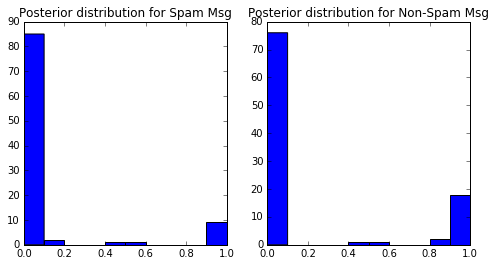

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(spam_posterior)
plt.title("Posterior distribution for Spam Msg")
plt.subplot(1, 2, 2)
plt.hist(ham_posterior)
plt.title("Posterior distribution for Non-Spam Msg")
plt.show()

In summary, because we are using training set to make predictions, it's very easy for the model to be over-confident.  Therefore we have lots of extreme probabilities, and few in the middle-ground.

* <b>HW2.4 Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.</b>

In [103]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Kuan Lin
## Description: reducer code for HW1.5

import sys
import re
import math
import string
import subprocess

files = sys.argv[1:]
data="/w261/hw2/enronemail_1h.txt"

spam_word_counts = {}
ham_word_counts = {}
spam_total_words = 0
ham_total_words = 0
unique_words = set()
spam_zero_count_processed = 0
ham_zero_count_processed = 0

# assume equal prior for spam and ham
spam_prior = 0.44
ham_prior = 0.56

def findWordCount(doc, word):
	count = 0
	for w in doc.split(' '):
		if w == word: count += 1
	return count

def spamWordProb(word):
	count = 0
	if word in spam_word_counts: count = spam_word_counts[word]
	# Applying laplace smoothing
	return float(count+1)/float(spam_total_words+len(unique_words))
	#return float(count)/float(spam_total_words)
	
def hamWordProb(word):
	count = 0
	if word in ham_word_counts: count = ham_word_counts[word]
	# Applying laplace smoothing
	return float(count+1)/float(ham_total_words+len(unique_words))
	#return float(count)/float(ham_total_words)
	
def classifyWithWordList(document, word_list):
	global spam_zero_count_processed
	global ham_zero_count_processed
	spam_logprob = math.log(spam_prior)
	ham_logprob = math.log(ham_prior)
	for word in word_list:
		#pattern = re.compile('[\s+]?(' + word + ')[\s+]?')
		word_count = findWordCount(document, word)
		spam_word_prob = spamWordProb(word)
		ham_word_prob = hamWordProb(word)
		if spam_word_prob > 0:
			spam_logprob += math.log(spam_word_prob)*word_count
		else:
			spam_zero_count_processed += 1
			spam_logprob += math.log(0.0001)*word_count
		if ham_word_prob > 0:
			ham_logprob += math.log(ham_word_prob)*word_count
		else:
			ham_zero_count_processed += 1
			ham_logprob += math.log(0.0001)*word_count
	# recover probability by taking exponential
	spam_prob = math.e**spam_logprob
	ham_prob = math.e**ham_logprob
	if spam_logprob > ham_logprob:
		return (1, spam_prob, ham_prob)
	else:
		return (0, spam_prob, ham_prob)

for line in sys.stdin:
    line = line.strip()
    if line == "": continue

    lineArr = line.split('\t')
    word = lineArr[0]
    count = int(lineArr[1])
    spam_flag = int(lineArr[2])

    if spam_flag == 1:
        if word == "class_total_words":
            spam_total_words += count
            continue
        if word in spam_word_counts:
            spam_word_counts[word] += count
        else:
            spam_word_counts[word] = count
    else:
        if word == "class_total_words":
            ham_total_words += count
            continue
        if word in ham_word_counts:
            ham_word_counts[word] += count
        else:
            ham_word_counts[word] = count

# perform classification with all words
unique_words = set([k for k in spam_word_counts.keys()] + [k for k in ham_word_counts.keys()])
total_msg_classified = 0
total_msg_correct = 0
tpc = 0
fpc = 0
tnc = 0
fnc = 0

cat = subprocess.Popen(["hadoop", "fs", "-cat", data], stdout=subprocess.PIPE)
for line in cat.stdout:
	line = line.strip()
	lineArr = line.split('\t')
	# check data integrity.  each valid line should have 4 fields, with second field equals either 0 or 1
	if len(lineArr) != 4 or (lineArr[1] != "0" and lineArr[1] != "1"): continue
	msg_id = lineArr[0]
	spam_flag = lineArr[1]
	subject_body = lineArr[2] + ' ' + lineArr[3]
	# remove punctuations
	subject_body = subject_body.translate(string.maketrans("",""), string.punctuation).strip().lower()
	predicted_results = classifyWithWordList(subject_body, unique_words)
	spam_prob = predicted_results[1]
	ham_prob = predicted_results[2]
	norm = spam_prob + ham_prob
	if norm > 0:
		spam_prob = spam_prob / norm
		ham_prob = ham_prob / norm
	else:
		spam_prob = 0
		ham_prob = 0
	spam_flag_predicted = str(predicted_results[0])
	total_msg_classified += 1
	if spam_flag == "1":
		if spam_flag_predicted == "1": tpc += 1
		else: fnc += 1
	else:
		if spam_flag_predicted == "1": fpc += 1
		else: tnc += 1
	if spam_flag_predicted == spam_flag: total_msg_correct += 1
	print '\t'.join([msg_id, spam_flag, spam_flag_predicted, str(spam_prob), str(ham_prob)])
print "-----------------------------------------------------"
print "feature size: " + str(len(unique_words))
print "total document classified: " + str(total_msg_classified)
print "total document correctly classified: " + str(total_msg_correct)
print "Spam zero prob processed: %s" % spam_zero_count_processed
print "Non-Spam zero prob processed: %s" % ham_zero_count_processed
print "TPR: %.4f"%(float(tpc)/float(tpc+fnc))
print "FPR: %.4f"%(float(fpc)/float(fpc+tnc))
print "accuracy: %.4f"%(float(total_msg_correct)/float(total_msg_classified))

Overwriting reducer.py


In [104]:
!cp mapper.py /data/w261/hw2/mapper.py; cp reducer.py /data/w261/hw2/reducer.py;
!chmod +x /data/w261/hw2/mapper.py; chmod +x /data/w261/hw2/reducer.py;
!hdfs dfs -rm -r /w261/hw2/hw2_4_output;
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/lib/hadoop-*streaming*.jar -mapper mapper.py -file /data/w261/hw2/mapper.py -reducer reducer.py -file /data/w261/hw2/reducer.py -input /w261/hw2/enronemail_1h.txt -output /w261/hw2/hw2_4_output;

rm: `/w261/hw2/hw2_4_output': No such file or directory
16/01/24 09:32:17 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/data/w261/hw2/mapper.py, /data/w261/hw2/reducer.py] [/usr/lib/hadoop/lib/hadoop-streaming-2.6.0.jar] /tmp/streamjob3103003523537383682.jar tmpDir=null
16/01/24 09:32:24 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 09:32:26 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 09:32:29 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 09:32:29 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 09:32:30 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453604265894_0025
16/01/24 09:32:32 INFO impl.YarnClientImpl: Submitted application application_1453604265894_0025
16/01/24 09:32:32 INFO mapreduce.Job: The url to track the job: http://ip-172-31-55-170.ec2.internal:8088/proxy/application_1453604265894_0025/
16/01/

In [105]:
# prediction result summary
!hdfs dfs -cat /w261/hw2/hw2_4_output/part-00000 | tail -15

0017.2003-12-18.GP	1	1	0.999999529496	4.70503735935e-07
0017.2004-08-01.BG	1	1	0	0
0017.2004-08-02.BG	1	1	0	0
0018.1999-12-14.kaminski	0	0	0	0
0018.2001-07-13.SA_and_HP	1	1	0	0
0018.2003-12-18.GP	1	1	0	0
-----------------------------------------------------	
feature size: 5663	
total document classified: 98	
total document correctly classified: 98	
Spam zero prob processed: 0	
Non-Spam zero prob processed: 0	
TPR: 1.0000	
FPR: 0.0000	
accuracy: 1.0000	


Training Accuracy is 100% with Laplace Smoothing.  Training Error is 0%

In [106]:
# extract posterior probs
import subprocess
spam_posterior = []
ham_posterior = []

# grab output from hdfs
cat = subprocess.Popen(["hadoop", "fs", "-cat", '/w261/hw2/hw2_4_output/part-00000'], stdout=subprocess.PIPE)
for line in cat.stdout:
    line = line.strip()
    if line == '': continue
    lineArr = line.split('\t')
    if len(lineArr) != 5: continue
    spam_posterior.append(float(lineArr[3]))
    ham_posterior.append(float(lineArr[4]))

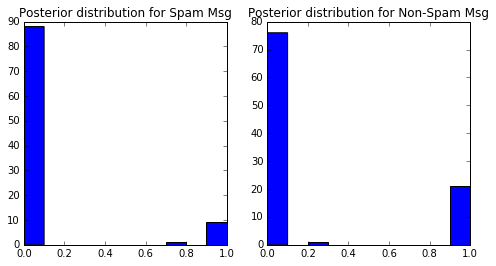

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(spam_posterior)
plt.title("Posterior distribution for Spam Msg")
plt.subplot(1, 2, 2)
plt.hist(ham_posterior)
plt.title("Posterior distribution for Non-Spam Msg")
plt.show()

With laplace smoothing, the posterior probability is even more extreme.  But this is because we are using training set to calculate prediction error.  In hold-out sets the posterior probability may not be so extreme.<br/>
With laplace smoothing, the training error is zero, meaning that the model has fitted all of the variations in the training data.  With non-smoothing, I was using 0.001 as the default probability for any words not existed in spam or non-spam class training sets.  As such, the non-smoothed model can fit to less variations in the training set and therefore resulted in a slightly higher training error.

* <b>HW2.5. Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset.</b>

In [108]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Kuan Lin
## Description: reducer code for HW1.5

import sys
import re
import math
import string
import subprocess

files = sys.argv[1:]
data="/w261/hw2/enronemail_1h.txt"

spam_word_counts = {}
ham_word_counts = {}
spam_total_words = 0
ham_total_words = 0
unique_words = set()
spam_zero_count_processed = 0
ham_zero_count_processed = 0

# assume equal prior for spam and ham
spam_prior = 0.44
ham_prior = 0.56

def findWordCount(doc, word):
	count = 0
	for w in doc.split(' '):
		if w == word: count += 1
	return count

def spamWordProb(word):
	count = 0
	if word in spam_word_counts: count = spam_word_counts[word]
	# ignore frequecy of less than 3
	if count < 3: count = 0
	# Applying laplace smoothing
	return float(count+1)/float(spam_total_words+len(unique_words))
	#return float(count)/float(spam_total_words)
	
def hamWordProb(word):
	count = 0
	if word in ham_word_counts: count = ham_word_counts[word]
	# ignore frequecy of less than 3
	if count < 3: count = 0
	# Applying laplace smoothing
	return float(count+1)/float(ham_total_words+len(unique_words))
	#return float(count)/float(ham_total_words)
	
def classifyWithWordList(document, word_list):
	global spam_zero_count_processed
	global ham_zero_count_processed
	spam_logprob = math.log(spam_prior)
	ham_logprob = math.log(ham_prior)
	for word in word_list:
		#pattern = re.compile('[\s+]?(' + word + ')[\s+]?')
		word_count = findWordCount(document, word)
		spam_word_prob = spamWordProb(word)
		ham_word_prob = hamWordProb(word)
		if spam_word_prob > 0:
			spam_logprob += math.log(spam_word_prob)*word_count
		else:
			spam_zero_count_processed += 1
			spam_logprob += math.log(0.0001)*word_count
		if ham_word_prob > 0:
			ham_logprob += math.log(ham_word_prob)*word_count
		else:
			ham_zero_count_processed += 1
			ham_logprob += math.log(0.0001)*word_count
	
	spam_prob = math.e**spam_logprob
	ham_prob = math.e**ham_logprob
	if spam_logprob > ham_logprob:
		return (1, spam_prob, ham_prob)
	else:
		return (0, spam_prob, ham_prob)

for line in sys.stdin:
    line = line.strip()
    if line == "": continue

    lineArr = line.split('\t')
    word = lineArr[0]
    count = int(lineArr[1])
    spam_flag = int(lineArr[2])

    if spam_flag == 1:
        if word == "class_total_words":
            spam_total_words += count
            continue
        if word in spam_word_counts:
            spam_word_counts[word] += count
        else:
            spam_word_counts[word] = count
    else:
        if word == "class_total_words":
            ham_total_words += count
            continue
        if word in ham_word_counts:
            ham_word_counts[word] += count
        else:
            ham_word_counts[word] = count

# perform classification with all words
unique_words = set([k for k in spam_word_counts.keys()] + [k for k in ham_word_counts.keys()])
total_msg_classified = 0
total_msg_correct = 0
tpc = 0
fpc = 0
tnc = 0
fnc = 0

cat = subprocess.Popen(["hadoop", "fs", "-cat", data], stdout=subprocess.PIPE)
for line in cat.stdout:
	line = line.strip()
	lineArr = line.split('\t')
	# check data integrity.  each valid line should have 4 fields, with second field equals either 0 or 1
	if len(lineArr) != 4 or (lineArr[1] != "0" and lineArr[1] != "1"): continue
	msg_id = lineArr[0]
	spam_flag = lineArr[1]
	subject_body = lineArr[2] + ' ' + lineArr[3]
	# remove punctuations
	subject_body = subject_body.translate(string.maketrans("",""), string.punctuation).strip().lower()
	predicted_results = classifyWithWordList(subject_body, unique_words)
	spam_prob = predicted_results[1]
	ham_prob = predicted_results[2]
	norm = spam_prob + ham_prob
	if norm > 0:
		spam_prob = spam_prob / norm
		ham_prob = ham_prob / norm
	else:
		spam_prob = 0
		ham_prob = 0
	spam_flag_predicted = str(predicted_results[0])
	total_msg_classified += 1
	if spam_flag == "1":
		if spam_flag_predicted == "1": tpc += 1
		else: fnc += 1
	else:
		if spam_flag_predicted == "1": fpc += 1
		else: tnc += 1
	if spam_flag_predicted == spam_flag: total_msg_correct += 1
	print '\t'.join([msg_id, spam_flag, spam_flag_predicted, str(spam_prob), str(ham_prob)])
print "-----------------------------------------------------"
print "feature size: " + str(len(unique_words))
print "total document classified: " + str(total_msg_classified)
print "total document correctly classified: " + str(total_msg_correct)
print "Spam zero prob processed: %s" % spam_zero_count_processed
print "Non-Spam zero prob processed: %s" % ham_zero_count_processed
print "TPR: %.4f"%(float(tpc)/float(tpc+fnc))
print "FPR: %.4f"%(float(fpc)/float(fpc+tnc))
print "accuracy: %.4f"%(float(total_msg_correct)/float(total_msg_classified))

Overwriting reducer.py


In [109]:
!cp mapper.py /data/w261/hw2/mapper.py; cp reducer.py /data/w261/hw2/reducer.py;
!chmod +x /data/w261/hw2/mapper.py; chmod +x /data/w261/hw2/reducer.py;
#!hdfs dfs -rm -r /w261/hw2/hw2_5_output;
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/lib/hadoop-*streaming*.jar -mapper mapper.py -file /data/w261/hw2/mapper.py -reducer reducer.py -file /data/w261/hw2/reducer.py -input /w261/hw2/enronemail_1h.txt -output /w261/hw2/hw2_5_output;

16/01/24 09:50:57 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/data/w261/hw2/mapper.py, /data/w261/hw2/reducer.py] [/usr/lib/hadoop/lib/hadoop-streaming-2.6.0.jar] /tmp/streamjob3398854005381174200.jar tmpDir=null
16/01/24 09:51:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 09:51:02 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 09:51:04 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 09:51:04 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 09:51:05 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453604265894_0026
16/01/24 09:51:06 INFO impl.YarnClientImpl: Submitted application application_1453604265894_0026
16/01/24 09:51:06 INFO mapreduce.Job: The url to track the job: http://ip-172-31-55-170.ec2.internal:8088/proxy/application_1453604265894_0026/
16/01/24 09:51:06 INFO mapreduce.Job: Running job: job_1453604

In [110]:
# prediction result summary
!hdfs dfs -cat /w261/hw2/hw2_5_output/part-00000 | tail -15

0017.2003-12-18.GP	1	1	0.999983062144	1.69378555673e-05
0017.2004-08-01.BG	1	0	0	0
0017.2004-08-02.BG	1	1	0	0
0018.1999-12-14.kaminski	0	0	0	0
0018.2001-07-13.SA_and_HP	1	1	0	0
0018.2003-12-18.GP	1	1	0	0
-----------------------------------------------------	
feature size: 5663	
total document classified: 98	
total document correctly classified: 96	
Spam zero prob processed: 0	
Non-Spam zero prob processed: 0	
TPR: 0.9535	
FPR: 0.0000	
accuracy: 0.9796	


Training Accuracy is 98% by ignoring token with frequency < 3, and applying Laplace Smoothing.  Training Error is 2%

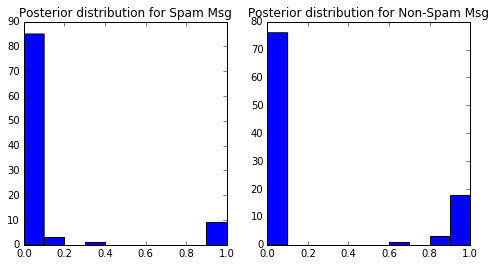

In [112]:
# extract posterior probs
import subprocess
spam_posterior = []
ham_posterior = []

cat = subprocess.Popen(["hadoop", "fs", "-cat", '/w261/hw2/hw2_5_output/part-00000'], stdout=subprocess.PIPE)
for line in cat.stdout:
    line = line.strip()
    if line == '': continue
    lineArr = line.split('\t')
    if len(lineArr) != 5: continue
    spam_posterior.append(float(lineArr[3]))
    ham_posterior.append(float(lineArr[4]))
    
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(spam_posterior)
plt.title("Posterior distribution for Spam Msg")
plt.subplot(1, 2, 2)
plt.hist(ham_posterior)
plt.title("Posterior distribution for Non-Spam Msg")
plt.show()

By ignoring tokens whose freqencies are less than 3, the posterior probability distributions are less extreme than ones using all tokens.  Training error increases slightly as the model now does not completeley overfit the training data.

* <b>HW2.6 Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm
* Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
* Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
* Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn</b>

In [1]:
data = "enronemail_1h.txt"

import string
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *

train_data_raw = []
train_labels = []

# load data from file
for line in open(data, 'r'):
    line = line.strip().lower()
    if line == "": continue
    lineArr = line.split('\t')
    if len(lineArr) != 4 or (lineArr[1] != "0" and lineArr[1] != "1"): continue
    spam_flag = lineArr[1]
    subject_body = lineArr[2] + ' ' + lineArr[3]
    subject_body = subject_body.translate(string.maketrans("",""), string.punctuation).strip().lower()
    train_data_raw.append(subject_body)
    train_labels.append(spam_flag)

# fit with count vectorizer
train_data = CountVectorizer().fit_transform(train_data_raw)
#print train_data.shape

# Multinomial NB with default settings:
multiNB_train_accuracy = MultinomialNB().fit(train_data, train_labels).score(train_data, train_labels)
print "MultinomialNB Accuracy: %.4f" % multiNB_train_accuracy

# Bernouli NB with default settings:
bernoulliNB_train_accuracy = BernoulliNB().fit(train_data, train_labels).score(train_data, train_labels)
print "BernoulliNB Accuracy: %.4f" % bernoulliNB_train_accuracy

MultinomialNB Accuracy: 1.0000
BernoulliNB Accuracy: 0.7857


The above code obtains classification accuracy scores for MultinomialNB and BernoulliNB classifier.  The accuracy score for our custom-built MultinomialNB is obtained previously.  Training error is just 1-accuracy.  Thus:

<table>
<tr><th></th><th>Train Accuracy</th><th>Train Error</th></tr>
<tr><th>Sklearn MultinomialNB</th><td>1.00</td><td>0.00</td></tr>
<tr><th>Sklearn BernoulliNB</th><td>0.7857</td><td>0.2143</td></tr>
<tr><th>Custom MultinomialNB with Laplace Smoothing</th><td>1.00</td><td>0.00</td></tr>
<tr><th>Custom MultinomialNB with Laplace Smoothing and ignoring token freq less than 3</th><td>0.98</td><td>0.02</td></tr>
<tr><th>Custom MultinomialNB No Smoothing</th><td>0.94</td><td>0.06</td></tr>
</table>

* Since we are calculating error rate using training data, it is not surprising that the MultinomialNB from Sklearn and our own custom-built model achieved zero training error.  This means that both models can explain all of the variations in the training data.  However, this does not gaurantee that the model will perform as well on future data.
* BernoulliNB model performs worse because it uses less information from the training data.  The BernoulliNB model only looks at if a term appears in a document, and does not take into account of how many times the term appear in the same document.  This will cause the BernoulliNB model to be unable to distinquish documents with the same words but with different frequencies.

* <b>HHW 2.6.1 OPTIONAL (note this exercise is a stretch HW and optional)
* Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error 
* Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain.
* Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.</b>

Result for Bernoulli Naive Bayes model is presented together in the above cell in HW2.6.  The main reason why the Bernoulli model performsly relatively poorly is because 1.) it does not account for relative frequency and only accounts the presence/omission of words 2.) it explicitly penalize omission of words, which is not optimal for Spam classification (omission of non-spam words should not increase the probability of a message being spam).  For these reasons we should select the Multinomial approach over the Bernoulli approach in spam classification.